# Mise en correspondance d’images
## Calcul des points d'intêret


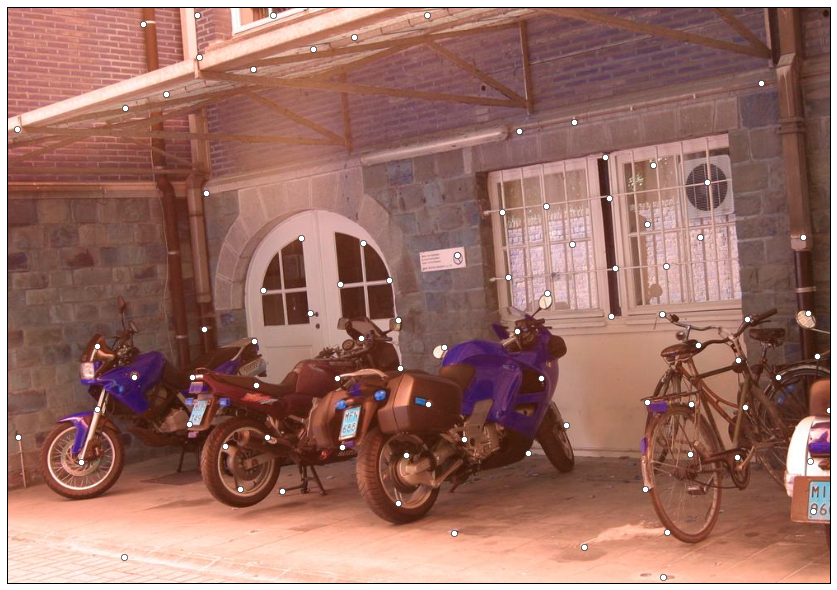

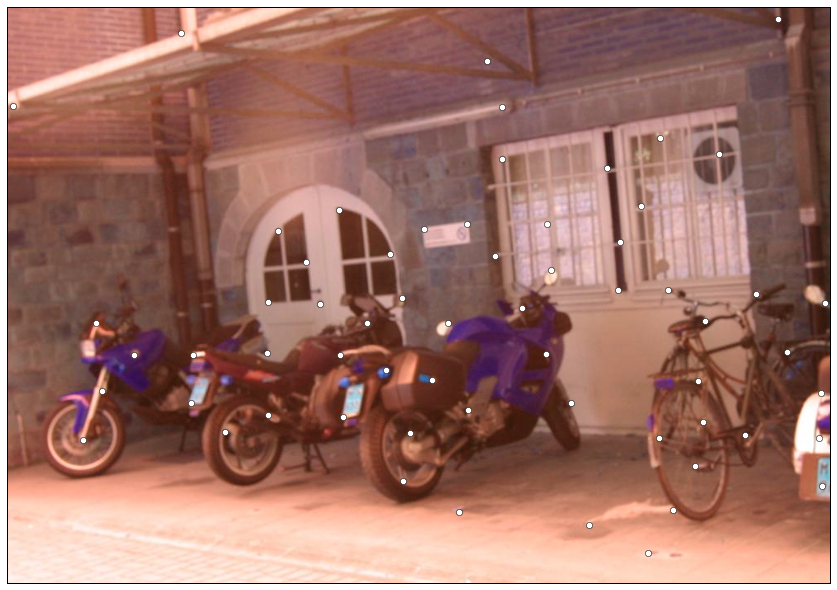

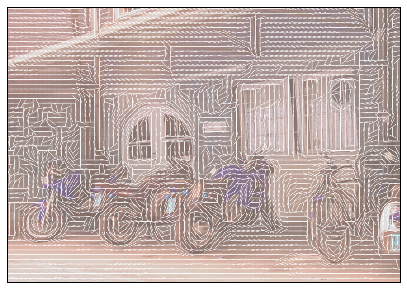

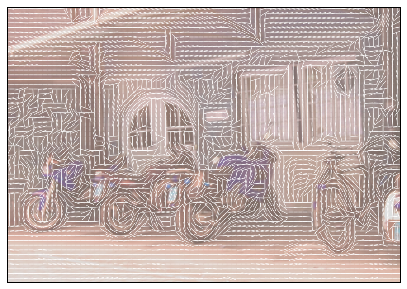

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
%matplotlib inline

def _plot(img):
    plt.subplots_adjust(left=0.0, right=2.0, bottom=0.0, top=2.0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

def plot_one(img):
    plt.figure()
    plt.subplot(121)
    _plot(img)
    
def plot_by_pair(img1, img2):
    plt.figure()
    plt.subplot(121)
    _plot(img1)
    plt.subplot(122)
    _plot(img2)



# goodFeaturesToTrack
def test_goodFeaturesToTrack(img_name):
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    points = cv2.goodFeaturesToTrack(gray, 100, 0.1, 50)
    points = [p[0] for p in points]
    
    plot_one(img)
    plt.plot(*zip(*points), marker='o', color='w', ls='')
    

test_goodFeaturesToTrack("bikes/img_7069.ppm")
test_goodFeaturesToTrack("bikes/img_7075.ppm")


def test_cornerMinEigenVal(img_name):
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape[:2]
    eigen = cv2.cornerEigenValsAndVecs(gray, 30, 7)
    eigen = eigen.reshape(h, w, 3, 2)  # [[e1, e2], v1, v2]
    flow = eigen[:,:,2]

    vis = img.copy()
    vis[:] = (192 + np.uint32(vis)) / 2
    d = 12
    points =  np.dstack( np.mgrid[d/2:w:d, d/2:h:d] ).reshape(-1, 2)
    for x, y in points:
       vx, vy = np.int32(flow[y, x]*d)
       cv2.line(vis, (x-vx, y-vy), (x+vx, y+vy), (255, 255, 255), 1, cv2.CV_AA)

    plot_one(vis, left=left)

test_cornerMinEigenVal("bikes/img_7069.ppm")
test_cornerMinEigenVal("bikes/img_7075.ppm", left=True)

## Calcul de la similarité entre les deux images